In [1]:
!pip install scikit-learn 
!pip install keras tensorflow
!pip install keras_nlp
!pip install gensim nltk
!pip install --upgrade tensorflow keras
!pip install --upgrade scikit-learn joblib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras_nlp
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import joblib
from imblearn.combine import SMOTEENN
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import nltk
nltk.download('punkt')   # For tokenization
nltk.download('stopwords')   # If you use stop words
nltk.data.path.append('C:/nltk_data')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mehak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mehak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = pd.read_csv(r"D:\Technology\CHATBOT ARENA - RESEARCH PAPER\train.csv", on_bad_lines='skip') 

df= pd.DataFrame(dataset)

In [4]:
# Create conditions for the new label column
conditions = [
    df['winner_model_a'] == 1,
    df['winner_model_b'] == 1,
    df['winner_tie'] == 1
]

# Define the values corresponding to each condition
values = [2, 3, 4]

# Create the new label column
df['y'] = np.select(conditions, values, default=0)  # Default can be set to 0 or any other value as needed

print(df.head())

       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   
3  ["How can I create a test set for a very rare ...   
4  ["What is the best way to travel from Tel-Aviv...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   
3  ["Creating a test set for a very rare category...   
4  ["The best way to travel from Tel Aviv to Jeru...   

 

In [5]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mehak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
#EDA
import plotly.express as px
model_df = pd.concat([df.model_a, df.model_b])
counts = model_df.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

# Create a bar plot with custom styling using Plotly
fig = px.bar(counts, x='LLM', y='Count',
             title='Distribution of LLMs',
             color='Count', color_continuous_scale='viridis')

fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability

fig.show()

In [7]:
#Preprocessing the data

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)    

df['prompt'] = df['prompt'].apply(preprocess_text)
df['response_a'] = df['response_a'].apply(preprocess_text)
df['response_b'] = df['response_b'].apply(preprocess_text)
df['model_a'] = df['model_a'].apply(preprocess_text)
df['model_b'] = df['model_b'].apply(preprocess_text)

In [8]:
# Initialize the tokenizer for prompts

df['prompt'] = df['prompt'].astype(str)
tokenizer_prompt = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_prompt.fit_on_texts(df['prompt'].values)

# Convert texts to sequences of integers
df['prompt'] = tokenizer_prompt.texts_to_sequences(df['prompt'].values)

In [9]:
# Initialize the tokenizer for response_a

df['response_a'] = df['response_a'].astype(str)
tokenizer_a = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_a.fit_on_texts(df['response_a'].values)

# Convert texts to sequences of integers
df['response_a'] = tokenizer_a.texts_to_sequences(df['response_a'].values)


In [10]:
# Initialize the tokenizer for response_b

df['response_b'] = df['response_b'].astype(str)
tokenizer_b = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_b.fit_on_texts(df['response_b'].values)

# Convert texts to sequences of integers
df['response_b'] = tokenizer_b.texts_to_sequences(df['response_b'].values)


In [11]:
#Initialize the tokenizer for model_a


df['model_a'] = df['model_a'].astype(str)
tokenizer_b = Tokenizer()

 #Fit the tokenizer on your texts
tokenizer_b.fit_on_texts(df['model_a'].values)

# Convert texts to sequences of integers
df['model_a'] = tokenizer_b.texts_to_sequences(df['model_a'].values)


In [12]:
# Initialize the tokenizer for model_b

df['model_b'] = df['model_b'].astype(str)
tokenizer_b = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_b.fit_on_texts(df['model_b'].values)

# Convert texts to sequences of integers
df['model_b'] = tokenizer_b.texts_to_sequences(df['model_b'].values)

In [13]:
# Inspect the data to identify non-iterable values
print(df['prompt'].apply(lambda x: type(x)).unique())  # Check types in 'prompt' column
print(df['response_a'].apply(lambda x: type(x)).unique())  # Check types in 'response_a' column

# Ensure that all elements are lists, converting single integers if necessary
#df['options'] = df['options'].apply(lambda x: [x] if isinstance(x, int) else x)
df['prompt'] = df['prompt'].apply(lambda x: [x] if isinstance(x, int) else x)
df['response_a'] = df['response_a'].apply(lambda x: [x] if isinstance(x, int) else x)
df['model_a'] = df['model_a'].apply(lambda x: [x] if isinstance(x, int) else x)
df['model_b'] = df['model_b'].apply(lambda x: [x] if isinstance(x, int) else x)
df['response_b'] = df['response_b'].apply(lambda x: [x] if isinstance(x, int) else x)
# Convert non-iterable values to lists
df['model_a'] = df['model_a'].apply(lambda x: [x] if not isinstance(x, (list, np.ndarray)) else x)
df['model_b'] = df['model_b'].apply(lambda x: [x] if not isinstance(x, (list, np.ndarray)) else x)



[<class 'list'>]
[<class 'list'>]


In [14]:
# Define the maximum length of sequences (you can adjust this as needed)
max_sequence_length = 250

# Pad sequences to ensure consistent input size
df['prompt'] = pad_sequences(df['prompt'].values, maxlen=max_sequence_length)
df['response_a'] = pad_sequences(df['response_a'].values, maxlen=max_sequence_length)
df['response_b'] = pad_sequences(df['response_b'].values, maxlen=max_sequence_length)
df['model_a'] = pad_sequences(df['model_a'].values, maxlen=max_sequence_length)
df['model_b'] = pad_sequences(df['model_b'].values, maxlen=max_sequence_length)

In [15]:
# Convert features to numpy arrays and ensure proper shape
X_prompt = np.array(df['prompt'].tolist()).reshape(-1, 1)
X_response_a = np.array(df['response_a'].tolist()).reshape(-1, 1)
X_response_b = np.array(df['response_b'].tolist()).reshape(-1, 1)
X_model_a = np.array(df['model_a'].tolist()).reshape(-1, 1)
X_model_b = np.array(df['model_b'].tolist()).reshape(-1, 1)
Y_winner_model_a = np.array(df['winner_model_a'].tolist()).reshape(-1, 1)
Y_winner_model_b = np.array(df['winner_model_b'].tolist()).reshape(-1, 1)
Y_winner_tie = np.array(df['winner_tie'].tolist()).reshape(-1, 1)

# Combine all feature arrays horizontally
X = np.hstack([X_prompt, X_response_a, X_response_b, X_model_a, X_model_b])

# Check the shape of X

# Check the shape of X
print(f"Shape of X: {X.shape}")

y = df['y']

Shape of X: (57477, 5)


In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train[501:10501]
y_train = y_train[501:10501]
X_test = X_test[:500]
y_test = y_test[:500]


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (10000, 5)
Shape of X_test: (500, 5)
Shape of y_train: (10000,)
Shape of y_test: (500,)


In [17]:
#Removing overlapping training examples

In [18]:
# Convert arrays to sets of tuples for comparison
#Converted to tuples for application of intersection method
train_set = set(map(tuple, X_train))
test_set = set(map(tuple, X_test))

# Find any overlap
overlap = train_set.intersection(test_set)
print(f"Number of overlapping samples: {len(overlap)}")

Number of overlapping samples: 11


In [19]:
# Convert overlap to a list of tuples
overlap_list = list(overlap)

# Create a mask for removing overlapping examples
overlap_indices = [i for i, row in enumerate(X_test) if tuple(row) in overlap_list]
mask = np.ones(len(X_test), dtype=bool)
mask[overlap_indices] = False

# Apply mask to remove overlapping examples
X_test_cleaned = X_test[mask]
y_test_cleaned = y_test[mask]


In [20]:
# Convert cleaned test set to a set of tuples
test_cleaned_set = set(map(tuple, X_test_cleaned))

# Verify no overlaps with training data
new_overlap = train_set.intersection(test_cleaned_set)
print(f"Number of overlapping samples after cleaning: {len(new_overlap)}")

Number of overlapping samples after cleaning: 0


In [21]:
print(f"y_test_cleaned shape: {y_test_cleaned.shape}")
print(f"X_test_cleaned shape: {X_test_cleaned.shape}")

y_test_cleaned shape: (72,)
X_test_cleaned shape: (72, 5)


In [22]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)

# Assuming X_train and y_train are your feature matrix and target labels

X_train, y_train = smote.fit_resample(X_test_cleaned, y_test_cleaned)

In [23]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Define RandomForest model and parameter grid
rf_clf = RandomForestClassifier(random_state=42)
param_grid = {
    'classifier__n_estimators': [100, 200, 500, 800],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

# Create a pipeline that applies SMOTE and then fits the classifier
pipeline = Pipeline([
   ('scaler', StandardScaler()),
   ('smote', SMOTE(random_state=42)),
   ('classifier', rf_clf)
])


# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                     scoring='accuracy', cv=cv, n_jobs=-1, verbose=2)

# Fit the model with resampled data
model.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = model.best_params_
best_score = model.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Make predictions on the test set (use the original X_test)
y_pred = model.predict(X_test_cleaned)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits
Best Parameters: {'classifier__bootstrap': True, 'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Cross-Validation Score: 0.5622222222222223


In [24]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Classification report (which includes precision, recall, and F1 score for each class)
print("Classification Report:")
print(classification_report(y_test_cleaned, y_pred))

# Alternatively, you can calculate precision, recall, and F1 score separately
# Calculate accuracy
accuracy = accuracy_score(y_test_cleaned, y_pred)
precision = precision_score(y_test_cleaned, y_pred, average='weighted')
recall = recall_score(y_test_cleaned, y_pred, average='weighted')
f1 = f1_score(y_test_cleaned, y_pred, average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Accuracy: {accuracy * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

           2       0.91      0.67      0.77        30
           3       0.77      0.97      0.86        31
           4       0.82      0.82      0.82        11

    accuracy                           0.82        72
   macro avg       0.83      0.82      0.81        72
weighted avg       0.83      0.82      0.81        72

Precision: 83.50%
Recall: 81.94%
F1 Score: 81.46%
Accuracy: 81.94%


In [25]:
# Save the trained model
joblib.dump(model, 'trained_model_chatbot.pkl')

['trained_model_chatbot.pkl']

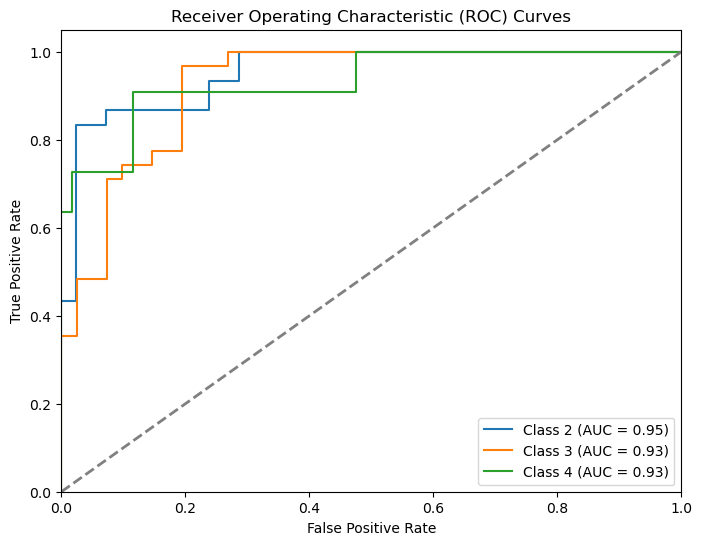

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming the classes are 2, 3, 4 (adjust to your class labels)
classes = [2, 3, 4]

# Binarize the output labels for one-vs-rest ROC calculation
y_test_binarized = label_binarize(y_test_cleaned, classes=classes)

# Get predicted probabilities
y_prob = model.predict_proba(X_test_cleaned)

# Initialize a plot for the ROC curves
plt.figure(figsize=(8, 6))

# Loop through each class to calculate and plot ROC and AUC
for i, class_label in enumerate(classes):
    # Calculate ROC curve and AUC score for the current class
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_score:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


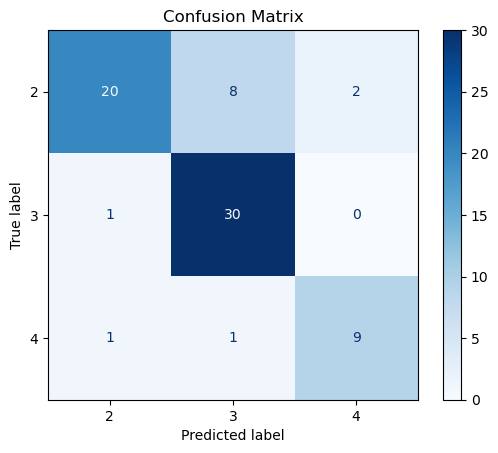

In [27]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_cleaned, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

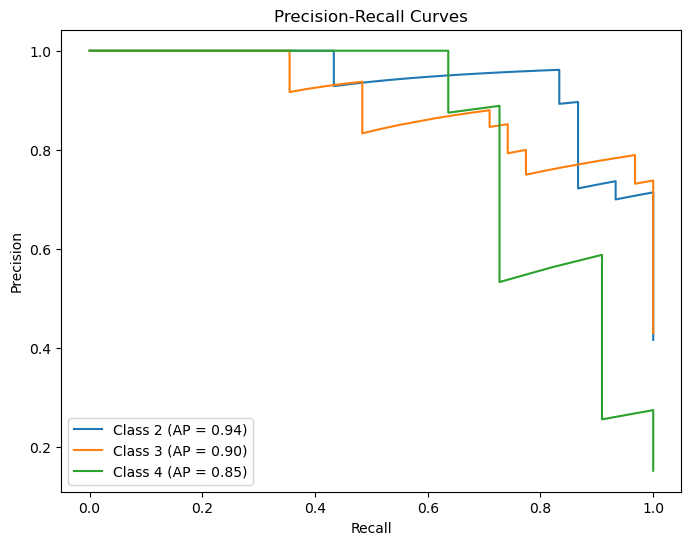

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize a plot for the precision-recall curves
plt.figure(figsize=(8, 6))

# Loop through each class to calculate and plot precision-recall curve and Average Precision (AP) score
for i, class_label in enumerate(classes):
    # Calculate precision-recall curve and AP score for the current class
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    ap_score = average_precision_score(y_test_binarized[:, i], y_prob[:, i])
    
    # Plot the precision-recall curve
    plt.plot(recall, precision, label=f'Class {class_label} (AP = {ap_score:.2f})')

# Plot formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


In [29]:
#Testing on some records of training data

In [30]:


data = {  "model_a_test" :  ["gpt-3.5-turbo-0613","mixtral-8x7b-instruct-v0.1","gpt-3.5-turbo-0o613","vicuna-13b","vicuna-13b","llama2-70b-steerlm-chat","claude-1","stablelm-tuned-alpha-7b","pplx-70b-online","gpt-4-0613"],
              "model_b_test" :   ["mistral-medium","vicuna-13b","vicuna-13b","koala-13b","claude-instant-1","gpt-4-0125-preview","gpt-4-0314","oasst-pythia-12b","gpt-3.5-turbo-1106","mistral-medium"],
              "response_a_test" : [["Function calling is the process of invoking or executing a function in a programming language. To call a function, you need to use the function's name followed by parentheses \"()\". Within the parentheses, you can pass arguments if the function requires any.\n\nHere is an example of how to call a function in Python:\n\npython\n# Define a function\ndef greet(name):\n    print(\"Hello, \" + name + \"!\")\n\n# Call the function\ngreet(\"John\")\n\n\nIn this example, the function \"greet\" is defined with a single parameter \"name\" which is used to print a greeting message. To call the function and pass an argument, we write \"greet(\"John\")\". This will execute the function and print \"Hello, John!\".\n\nIt is important to note that the function should be defined before calling it in most programming languages, as the interpreter needs to know about the function's existence before it can be called."],
                          ["Water is actually used in a bath tub. A bath tub is specifically designed to be filled with water for the purpose of bathing. You fill the tub with water, add bath salts or bubbles if you like, and then soak in the water to clean your body and relax.\n\nIf you are asking why water is not used in a bath tub in the same way that it is used in a swimming pool or a hot tub, there are a few reasons for this. First, bath tubs are much smaller than swimming pools or hot tubs, so they cannot hold as much water. This means that the water in a bath tub can get dirty and contaminated more quickly than the water in a larger body of water.\n\nAdditionally, bath tubs are not designed to be continuously filled with water. They are meant to be filled, used for bathing, and then drained. This helps to prevent the buildup of bacteria and other contaminants in the water.\n\nFinally, it is important to note that bath tubs are typically used for personal hygiene, and it is generally not recommended to share a bath tub with multiple people due to the risk of spreading germs. In contrast, swimming pools and hot tubs are often used by multiple people at the same time, so they need to be treated with chemicals to kill bacteria and other contaminants."],
                          ["\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \u0437\u0435\u043c\u043b\u0435\u0432\u043b\u0430\u0434\u0435\u043b\u044c\u0446\u044b \u0438\u0441\u043f\u043e\u043b\u044c\u0437\u043e\u0432\u0430\u043b\u0438 \u043f\u0440\u043e\u0433\u0440\u0430\u043c\u043c\u043d\u043e\u0435 \u043e\u0431\u0435\u0441\u043f\u0435\u0447\u0435\u043d\u0438\u0435 \u0434\u043b\u044f \u0441\u0433\u043e\u0432\u043e\u0440\u0430 \u0432 \u043e\u0442\u043d\u043e\u0448\u0435\u043d\u0438\u0438 \u0446\u0435\u043d \u043d\u0430 \u0430\u0440\u0435\u043d\u0434\u0443, \u0433\u043e\u0432\u043e\u0440\u0438\u0442 \u0438\u0441\u043a \u0432 \u0412\u0430\u0448\u0438\u043d\u0433\u0442\u043e\u043d\u0435."],
                       ["Jism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rakhta,\nNahi rakhta tho kisi ka samna,\nNahi rakhta tho kisi ka ajna.\n\nJism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rakhta,\nNahi rakhta tho kisi ka samna,\nNahi rakhta tho kisi ka ajna.\n\nJism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rakhta,\nNahi rakhta tho kisi ka samna,\nNahi rakhta tho kisi ka ajna.\n\nJism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rakhta,\nNahi rakhta tho kisi ka samna,\nNahi rakhta tho kisi ka ajna.\n\nJism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rakhta,\nNahi rakhta tho kisi ka samna,\nNahi rakhta tho kisi ka ajna.\n\nJism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rakhta,\nNahi rakhta tho kisi ka samna,\nNahi rakhta tho kisi ka ajna.\n\nJism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rakhta,\nNahi rakhta tho kisi ka samna,\nNahi rakhta tho kisi ka ajna.\n\nJism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rakhta,\nNahi rakhta tho kisi ka samna,\nNahi rakhta tho kisi ka ajna.\n\nJism ko kisi ka paisa nahi,\nWo kisi ka jaan nahi rak"],
                       ["To delete a tun\/tap device named \"kcptun\" on a server, you can use the \"tunctl\" command. Here are the steps to do it:\n\n1. First, identify the device name and the network interface that the tun\/tap device is associated with. You can use the \"ip link\" command to list all network interfaces on the server. Look for an interface that has an IP address in the 172.16.0.0\/12 range, which is the range used by kcptun devices.\n\nExample:\n```bash\n$ ip link\n1: lo: lo:\n2: eth0: eth0: gigabit: Intel Corporation 82540M Gigabit Controller [1026:0182] (rev 01)\n    inet 192.168.1.100  netmask 255.255.255.0  broadcast 192.168.1.255\n    inet6 fe80::a00:27ff:fe3e:aee3  prefixlen 64  scopeid 0x20<link>\n    ether 08:00:27:3e:ae:e3  txqueuelen 1000  (Ethernet)\n    RX packets 11277  bytes 10596884 (1.0 MiB)\n    RX errors 0  dropped 0  overruns 0  frame 0\n    TX packets 25707  bytes 6043080 (6.1 MiB)\n    TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0\n3: kcptun0: kcptun0: br-634c1f4590a5  txqueuelen 1000  (Tun\/Tap)\n    inet 10.244.0.1\/24  netmask 255.255.255.0  broadcast 10.244.0.255"],
                       ["The Cypher Query Language is a declarative language used to query and manipulate data in graph databases. It was developed by Neo4j, a popular open-source graph database, and has since become a widely used language in the graph database community.\n\nCypher is designed to make it easy to query and traverse the relationships between data points in a graph database. It uses a pattern-matching syntax to describe the relationships between entities, and provides a set of functions and operators to manipulate and transform data.\n\nCypher is particularly well-suited to applications where the data can be represented as a graph, such as social networks, transportation networks, and recommendation systems. It provides an intuitive and flexible way to query and analyze these types of data, and can help uncover hidden patterns and insights that might be difficult to discover using traditional relational databases.\n\nIn addition to its use in Neo4j, Cypher has also been adopted by other graph databases, including Microsoft's Azure Cosmos DB and Apache Spark's GraphX library. This has helped to establish it as a widely recognized and supported language in the graph database community."],
                       ["This is very difficult to estimate precisely given the available data. Here is my rough reasoning:\n\n\u2022 There are approximately 1,000 museums in the U.S. that contain dinosaur fossils or replicas. Not all of these have full skeletons, but many of the major natural history museums do. As a rough guess, if 25-50% of these museums have at least one full dinosaur skeleton, that would suggest there are between 250 to 500 full dinosaur skeletons in U.S. museums.\n\n\u2022 There are also many dinosaur fossils held in university collections that are not on public display. There are hundreds of universities, colleges, and community colleges in the U.S. with geology, paleontology, and natural history programs. If even a small fraction of these have dinosaur skeletons in their collections, that could represent hundreds more specimens.\n\n\u2022 Private collectors also own some number of dinosaur skeletons, though these are not tracked or documented as systematically. There are likely at least a few dozen in private hands.\n\n\u2022 Many dinosaur skeletons are still in the ground, waiting to be discovered. Hundreds of new specimens are discovered each year, though only a fraction of these are complete or well-preserved enough to be museum displays. Over decades and centuries, many more are likely yet to be found.\n\nSo putting these factors together, a conservative estimate might be that there are at least 1,000 to 2,000 dinosaur skeletons currently in the U.S., either on display, in museum collections, or in private hands. The true number could be higher, perhaps by a substantial margin. But this provides a sense of the minimum based on the available evidence. Clearly, this is not a high-precision estimate and there are many uncertainties, but I hope this at least outlines the basis for my rough reasoning. Please let me know if you would like me to clarify or expand on any part of this answer.","Estimating the number of stop signs in America is challenging given the lack of comprehensive data. Here is my rough reasoning:\n\n\u2022 There are over 4 million miles of roads in the U.S., including federal highways, state highways, county roads, and local streets. Not all of these roads have stop signs, but many smaller roads and intersections do. If even a small fraction of the total road miles, say 10-25%, have at least one stop sign, that would suggest 400,000 to 1 million miles of roads with stop signs.\n\n\u2022 Most stop signs control smaller residential or neighborhood road intersections. There are tens of millions of local road intersections in the U.S. If 10-30% of these have stop signs, that could amount to 3 million to 9 million stop signs or more. \n\n\u2022 Stop signs are also commonly used in parking lots, driveways, and private roads to control traffic flow. There are hundreds of millions of parking spaces and driveways in the U.S. If a small percentage of these have stop signs, that could represent at least a million or more additional signs.\n\n\u2022 Stop signs need to be regularly replaced as they become damaged, faded, or vandalized. Local governments likely replace at least 10-20% of their stop signs each year, so there are likely millions of new stop signs installed annually across the country. \n\n\u2022 However, not all stop signs are installed or used properly according to traffic standards. Some are installed unnecessarily or in locations where they do not achieve their intended purpose. So the actual number may be somewhat lower than these estimates.\n\nPutting this all together, a reasonable estimate for the total number of stop signs currently in use in America could be in the range of 10 million to 30 million or more. But there are many uncertainties in these figures, so treat this as a rough initial estimate. The actual number could be substantially higher or lower. Let me know if you would like me to clarify or expand on any part of this answer.","Estimating the number of lines of code for a midsized company is challenging without more details, but here is my rough reasoning:\n\n\u2022 A \"midsized\" software company likely has between 100 to 1,000 employees, with a sizable percentage (maybe 25-75%) of those being software engineers or developers. With 50-500 developers, that could represent 10-50 development teams of maybe 5-20 people each.\n\n\u2022 Each development team likely works on several codebases or repositories, maybe 3 to 10 on average. So there are potentially 30-500 distinct codebases, of varying sizes, across the company. \n\n\u2022 The size of a codebase can vary greatly based on factors like:\n\n\u203a Age of the code - Legacy codebases that have been worked on for years or decades often contain more lines of code. Newer codebases usually start smaller.\n\n\u203a Complexity of the software - Simpler web or mobile apps may only be 10s of thousands of lines, while an enterprise system could be 1 million lines or more.\n\n\u203a Programming languages used - Some languages like Java, C++, and C# typically result in more lines of code than languages like Python or Ruby for the same functionality.\n\n\u203a Code conventions - Strict, verbose coding styles can often result in more lines of code than terse, compact styles. \n\n\u2022 As a rough average, a reasonably complex enterprise application (which many midsized companies build and maintain) might contain 100,000 to 1 million lines of code.  Some larger systems could be multimillion lines.\n\nPutting this all together, I would conservatively estimate the total lines of code for a midsized software company to be at least 10 million, but potentially 100 million lines of code or more for a company at the larger end of that range, or with a number of complex legacy systems. However, there is a lot of uncertainty in these figures, and the actual number could be substantially higher or lower depending on the details of the company and systems in question.\n\nLet me know if you would like me to clarify or expand on any part of this answer. I could provide a more customized estimate if you are able to provide more details about the specific company and codebases.","Estimating the total number of bullets fired in World War II is very difficult given the scale and complexity of the war. However, here is my rough reasoning:\n\n\u2022 There were over 60 million military personnel mobilized during WWII, including over 12 million in the U.S. armed forces alone. If even a small fraction of these troops, say 10-20%, were actively engaged in combat at some point, that would represent 6-12 million combatants.\n\n\u2022 Each of these combatants likely had access to and made use of thousands of rounds of small arms ammunition over the course of the war. If they each fired between 1,000 to 10,000 rounds from rifles, machine guns, pistols, etc. that would represent 6 to 120 billion rounds total. The actual number was probably somewhere in the middle, perhaps 10,000 to 50,000 rounds per combatant, suggesting 60 billion to 600 billion rounds or more from small arms alone.\n\n\u2022 In addition to small arms, WWII saw the widespread use of artillery ranging from light mortars to heavy naval guns. Artillery rounds during major engagements could easily number in the tens or hundreds of thousands per day. Over thousands of days of combat, potentially billions of artillery shells were fired. If 1-10 shells were fired for every small arms round, that could represent another 60 billion to 600 billion rounds.\n\n\u2022 Ammunition for larger weapons like tanks, aircraft-mounted cannons, naval guns, and other heavy weapons also numbered in the billions of rounds combined over the full span of the war. \n\n\u2022 However, not all ammunition was fired at the enemy, as training, accidental discharges, and waste also accounted for a sizable percentage of total rounds produced and shipped. So the actual number fired in combat was likely somewhat lower than these estimates.\n\nIn total, I would conservatively estimate that at least 100 billion to 1 trillion or more rounds were fired during WWII between all sides. The actual number is likely within the higher end of this range, if not higher still. But there are many uncertainties, so treat this as a initial rough estimate. Let me know if you would like me to clarify or expand on any part of this answer.","OK, let's estimate this step-by-step:\n\n\u2022 The average dollar bill is about 6.14 inches long or 0.15 meters. \n\n\u2022 The distance from the Earth to the moon is about 238,900 miles or 384,400 kilometers.\n\n\u2022 So we would need (384,400,000 meters \/ 0.15 meters per bill) = 2.56 billion dollar bills to reach the moon.\n\nHowever, there are a few issues with this simple calculation:\n\n1. Dollar bills are not perfectly rigid, flat strips. They have some thickness and flexibility, so the actual length of bills attached end-to-end would be greater than just their linear dimensions. I will estimate about 10% extra length to account for this, so 2.81 billion bills.\n\n2. The distance between the Earth and moon varies over time due to their elliptical orbits. The moon's orbit can be up to 251,900 miles at its closest (perigee) and up to 252,700 miles at its furthest (apogee). So we need to use an average \"mean\" distance for our calculation. The exact mean distance varies slightly over time, but around 238,900 miles is a reasonable figure to use.\n\n3. The dollar bills would have mass, so as we build up the chain, it would start to sag under its own weight, requiring more bills to reach the same distance. The mass of 2.8 billion bills is not negligible. However, the sag would not be too significant until the higher reaches of the stack, so I will roughly estimate it might require 10% more bills to account for sag, or 3.09 billion bills.\n\n4. We would have to attach the bills somehow, and the connections and attachments would also add length. However, since we only need a rough estimate, I will ignore this factor.\n\nSo in summary, after accounting for the flexibility, variable distance, and sag under the weight of the bills, a reasonable estimate is that it would take between 3 to 3.5 billion dollar bills attached end-to-end to reach the average distance from the Earth to the moon. Let me know if you would like me to clarify or expand on any part of this answer."],
                       ["Anguilla is the larger of the two, with more to see, and is also more developed."],
                       ["The question of why the philosopher stopped laughing is not directly related to the ontological question of why anything exists. However, the story of the three Greek philosophers discussing the Fundamental Ontological Question provides a humorous anecdote that can be interpreted in various ways.\n\nOne possible interpretation is that the philosophers, after a lengthy discussion, realized the futility of their pursuit and were reminded of their human limitations. This realization led to the owls dropping their \"presents\" on the philosophers' foreheads, which in turn awakened them. The hoot of the owls might have startled them, causing them to laugh simultaneously. One philosopher stopped laughing because he realized the absurdity of their situation: they were attempting to answer an unanswerable question while being subject to the same physical and biological constraints as other living beings. This realization might have led him to stop laughing and reflect on the nature of their existence and the limitations of their philosophical pursuits.","The scenario you described involves a group of philosophers and their thoughts on laughter. However, the search results provided do not directly address the specific situation you mentioned. Nonetheless, some philosophers are known for their thoughts on laughter and humor, such as Democritus, who was nicknamed the \"laughing philosopher\", and Henri Bergson, who wrote an essay on the meaning of the comic. Other philosophers, like Nietzsche, also discussed laughter in the context of their philosophy."],
                       ["1. Cultural: A new art movement, called \"Neo-Techism,\" emerges, blending traditional art styles with evolving technology, such as AR and VR. It gains quick popularity and is embraced globally, significantly impacting the art world.\n\n2. Social: As a response to the ongoing digital revolution, a significant portion of the world's population begins to adopt a \"digital minimalism\" lifestyle, forming communities that limit their use of technology. This movement gains momentum and significantly influences the tech industry, prompting companies to create products promoting balance between digital and non-digital life.\n\n3. Political: A surprising coalition forms between several major and minor political parties in the United States, breaking the longstanding two-party dominance. This leads to a major political reform, introducing a multi-party system that changes the dynamics of the 2024 presidential election. \n\n4. Cultural: In a surprising twist, Hollywood decides to halt the production of superhero films, citing over-saturation of the market. Instead, they shift focus towards producing films that emphasize on human resilience and real-life heroes.\n\n5. Social: With the increase in climate change awareness and the popularity of plant-based diets, a new social movement called \"Eco-Cuisine\" becomes a trend. It advocates for sustainable eating habits, which includes not just plant-based diets but also using food technology to create synthetic but eco-friendly food.\n\n6. Political: A country, previously not known for its tech advancements, emerges as a new global leader in AI and robotics. This unexpected shift significantly changes the political landscape, forcing other countries to rethink their strategic alliances and policies."]],
            "response_b_test" : [["Function calling is the process of invoking a function in a program. A function is a block of code that performs a specific task and can be reused multiple times in a program. Functions help to organize and modularize code, making it more readable and maintainable.\n\nTo call a function, you simply write the name of the function followed by parentheses () containing any arguments or parameters that the function requires. Here's an example:\n\nfunction greet(name) {\n  console.log(\"Hello, \" + name);\n}\n\n\/\/ Call the greet function and pass in the argument \"Alice\"\ngreet(\"Alice\");\n\nIn the example above, the function greet takes one parameter, name, which is used inside the function to print a greeting message. To call the function, we write the name of the function (greet) followed by parentheses containing the argument \"Alice\". When the function is called, the argument \"Alice\" is passed to the function, where it is assigned to the name parameter. The function then uses the name parameter to print the greeting message \"Hello, Alice\".\n\nFunctions can also return values, which can be assigned to variables or used in expressions. For example:\n\nfunction addNumbers(a, b) {\n  return a + b;\n}\n\n\/\/ Call the addNumbers function and assign the result to the variable sum\nvar sum = addNumbers(3, 5);\nconsole.log(sum); \/\/ Output: 8\n\nIn the example above, the function addNumbers takes two parameters, a and b, adds them together, and returns the result. To call the function, we write the name of the function (addNumbers) followed by parentheses containing the arguments 3 and 5. The function calculates the sum of the two arguments (3 + 5 = 8) and returns the result (8). We then assign the result to the variable sum and print it to the console."],
                       ["Water is not used in a bath tub because it is not a suitable medium for conducting electricity. In a bathtub, the water is used for soaking and cleaning the body, and it is not intended to be used as a conductor of electricity. Additionally, water is a poor conductor of electricity, which means that it would not be able to carry the electrical current required to power the water heater elements in the bathtub.\n\nIn order to provide hot water for a bathtub, a separate water heater is typically used. This water heater is designed to heat the water to the desired temperature and deliver it to the bathtub through a dedicated hot water supply line. The water heater elements are typically located inside the water heater, and they are not exposed to the water in the bathtub. This keeps the water in the bathtub clean and free from any potential electrical hazards.\n\nOverall, the use of water in a bathtub is not practical or safe for powering electric elements. Instead, a dedicated water heater is used to provide hot water for the tub."],
                       ["\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \u0441\u043e\u0431\u0441\u0442\u0432\u0435\u043d\u043d\u0438\u043a\u0438 \u043d\u0435\u0434\u0432\u0438\u0436\u0438\u043c\u043e\u0441\u0442\u0438 \u0438\u0441\u043f\u043e\u043b\u044c\u0437\u043e\u0432\u0430\u043b\u0438 \u043f\u0440\u043e\u0433\u0440\u0430\u043c\u043c\u043d\u043e\u0435 \u043e\u0431\u0435\u0441\u043f\u0435\u0447\u0435\u043d\u0438\u0435 \u0434\u043b\u044f \u0441\u0433\u043e\u0432\u043e\u0440\u0430 \u043f\u043e \u0446\u0435\u043d\u0435 \u0430\u0440\u0435\u043d\u0434\u044b, \u0433\u043e\u0432\u043e\u0440\u0438\u0442 \u0438\u0441\u043a \u0432 \u0412\u0430\u0448\u0438\u043d\u0433\u0442\u043e\u043d\u0435."],
                       ["In the realm of selflessness dwells the true believer\n\nWhere the heart is pure, the mind is clear\n\nThe selfless one walks with grace and poise\n\nThrough life's trials and tribulations\n\nThe selfless one stands tall and resolute\n\nFor true selflessness is the key to greatness\n\nIt is the path to eternity\n\nFor the selfless one is free from the burden of self\n\nAnd finds true peace and happiness within."],
                       ["To delete kcptun on a server, follow these steps:\n\n1. Stop the kcptun service:\n\nbash\nsystemctl stop kcptun\n\n\n2. Remove the kcptun service:\n\nbash\nsystemctl disable kcptun\nsystemctl disable --now kcptun\n\n\n3. Delete the kcptun configuration file:\n\nbash \nrm -f \/etc\/kcptun\/server.json\n\n\n4. Delete the kcptun binary:\n\nbash\nrm -f \/usr\/bin\/kcptun \n\n\n5. Delete any leftover kcptun files and directories:\n\nbash\nrm -rf \/etc\/kcptun\nrm -rf \/var\/log\/kcptun\n\n\n6. Remove kcptun from the init system:\n\nFor systemd:\nbash\nrm -f \/lib\/systemd\/system\/kcptun.service\n \n\nFor openrc: \nbash\nrm -f \/etc\/init.d\/kcptun\n\n\nThat will completely remove kcptun and any configuration from your server. You'll need to repeat the process on any client machines that were connecting to this kcptun server.\n\nHope this helps! Let me know if you have any other questions."],
                       ["Certainly! The Cypher Query Language, often simply referred to as Cypher, is a declarative query language created by Neo4j for its graph database. It is designed to be intuitive and easy to learn, drawing upon familiar SQL-like syntax but tailored specifically for querying and manipulating graph data structures. Graph databases are designed to store and navigate relationships efficiently and are particularly well-suited for dealing with connected data, such as social networks, recommendation systems, and network analysis.\n\nCypher focuses on the simplicity of graph patterns to express what data to retrieve or how to modify data within the graph. The language allows you to state what you want to select, insert, update, or delete in the graph database without requiring you to describe exactly how to do it, making it a high-level, declarative language.\n\nKey Concepts and Features of Cypher:\n\n1. *Nodes and Relationships: In Cypher, data is represented as nodes (entities) and relationships (the connections between entities). Nodes can have labels to categorize them and properties as key-value pairs. Relationships are directional and also can have properties.\n\n2. **Pattern Matching: One of the core features of Cypher is its ability to easily match patterns within the graph. This is used both for querying data by finding specific shapes or structures in the graph and for creating or modifying data.\n\n3. **Cypher Syntax*: The syntax of Cypher is reminiscent of ASCII art; it visually represents the graph patterns. For example, (a:Person)-[:KNOWS]->(b:Person) could represent a pattern where a person a knows another person b. Here, :Person is a label indicating the node is a person, and [:KNOWS] represents a relationship of type \"KNOWS\" between them.\n\n4. *CRUD Operations*: Cypher supports creating, reading, updating, and deleting data within a Neo4j database through its syntax. For instance, CREATE, MATCH, MERGE, SET, DELETE, and REMOVE are some of the key operations.\n\n5. *Aggregation, Ordering, and Functions: Cypher provides capabilities for aggregating data, ordering results, and applying functions for data transformation and analysis, similar to SQL.\n\n6. **Parameters*: Cypher supports the use of parameters in queries, which helps in writing more efficient and secure queries.\n\nCypher has been influential in the development of property graph query languages, contributing to the creation of open standards for graph databases. Its approachability and expressive power make it a popular choice for developers working with graph databases to model complex, connected data in various domains."],
                       ["Estimating the exact number of dinosaur skeletons in the United States is challenging due to the continuous discoveries and excavations of new specimens. However, I can provide a rough estimate based on some available information.\n\nThere are more than 1,500 accredited museums in the United States, and many of these museums have natural history collections that may include dinosaur skeletons or partial specimens. However, not all museums will have dinosaur skeletons, and some may have only a few or even just one specimen. Additionally, some dinosaur skeletons may be held at private collections, research institutions, or universities. \n\nAssuming that around 20% of these museums have dinosaur skeletons, and each of those museums has an average of 5 dinosaur skeletons, we can estimate the number of dinosaur skeletons in the United States as follows:\n\n1,500 museums * 20% = 300 museums with dinosaur skeletons\n300 museums * 5 skeletons per museum = 1,500 dinosaur skeletons\n\nThis estimate of 1,500 dinosaur skeletons in the United States is a rough approximation and should be taken with a grain of caution. The actual number may vary significantly depending on many factors, such as the number of skeletons held in private collections or research institutions, and the rate of new discoveries in the field of paleontology.","Estimating the number of stop signs in the United States is challenging, as the number will depend on various factors such as population density, road infrastructure, and urban planning regulations. However, I can provide a rough estimation based on some assumptions.\n\nAccording to the Federal Highway Administration, there are approximately 4.18 million miles of roads in the United States. Let's assume that on average, there is one stop sign per every 0.25 mile (equivalent to 1,320 feet) in urban and suburban areas, while in rural areas, there is one stop sign per every 1 mile. \n\nApproximately 19% of the total land area in the United States is considered urban, while the remaining 81% is rural. Therefore, we can estimate the number of stop signs in urban and rural areas separately and then add them up:\n\nUrban roads: 4.18 million miles * 19% = 794,200 miles\nRural roads: 4.18 million miles * 81% = 3,385,800 miles\n\nUrban stop signs: 794,200 miles * (1 stop sign \/ 0.25 mile) = 3,176,800 stop signs\nRural stop signs: 3,385,800 miles * (1 stop sign \/ 1 mile) = 3,385,800 stop signs\n\nTotal stop signs: 3,176,800 (urban) + 3,385,800 (rural) = 6,562,600 stop signs\n\nThis rough estimate suggests there are about 6.56 million stop signs in the United States. However, it's important to note that this estimation is based on assumptions and may not be entirely accurate. The actual number may vary depending on factors such as local traffic regulations, road conditions, and regional differences in urban planning.","Estimating the number of lines of code in a codebase for a mid-sized company that hires software engineers can vary significantly depending on the company's industry, the complexity of the software, and the number of software applications they maintain.\n\nAs a rough estimate, let's consider a mid-sized company with 50-200 software engineers. Typically, software engineers work on multiple projects with varying complexity. A single software engineer might write anywhere from 100 to 1,000 lines of code per day, depending on the task and level of experience. However, not all lines of code written will end up in the final codebase, as some will be refactored, optimized, or removed over time.\n\nLet's assume that, on average, each software engineer contributes a net of 5,000 lines of code per year to the company's codebase. \n\nFor a mid-sized company with 100 software engineers (as an example), the annual contribution to the codebase would be:\n\n100 software engineers * 5,000 lines of code per engineer per year = 500,000 lines of code per year\n\nNow, let's assume that the company has been in operation for 10 years and has been maintaining and growing its codebase during that time. In this scenario, the total number of lines of code in the codebase would be:\n\n500,000 lines of code per year * 10 years = 5,000,000 lines of code\n\nSo, a rough estimate for the number of lines of code in a mid-sized company's codebase with 100 software engineers and 10 years of operation would be around 5 million lines of code. Keep in mind that this is a rough estimate and the actual number of lines of code can vary greatly depending on factors such as the complexity of the software, the number of software applications, and the company's industry.","Estimating the total number of bullets fired during World War II is challenging due to the lack of detailed records and the immense scale of the conflict. However, we can attempt to provide a rough estimate based on some assumptions.\n\nWorld War II lasted from 1939 to 1945 and involved more than 100 million people from over 30 countries. The major participants included the Allies (United States, Soviet Union, United Kingdom, China, and others) and the Axis powers (Germany, Italy, and Japan). Millions of soldiers were involved in various combat situations during the war, such as infantry battles, tank skirmishes, and air raids.\n\nAssuming, on average, each soldier fired 100 bullets per month (which is a conservative estimate considering the intensity of some battles), we can estimate the number of bullets fired per soldier:\n\n100 bullets per month * 12 months * 6 years = 7,200 bullets per soldier\n\nEstimating the total number of soldiers who served during the war is difficult. However, let's assume that approximately 50 million soldiers participated in combat during the war, considering that the total number of people involved in the war was over 100 million.\n\nTo estimate the total number of bullets fired, we can multiply the number of bullets fired per soldier by the estimated number of soldiers:\n\n50,000,000 soldiers * 7,200 bullets per soldier = 360,000,000,000 bullets\n\nThis rough estimate suggests that around 360 billion bullets were fired during World War II. However, it's important to note that this estimation is based on assumptions and may not be entirely accurate. The actual number could be higher or lower depending on factors such as the intensity of battles, the number of soldiers involved in combat, and the availability of ammunition.","To estimate how many dollar bills it would take to reach the moon when attached end to end, we need to know the dimensions of a dollar bill and the average distance from the Earth to the Moon.\n\nA U.S. dollar bill is approximately 6.14 inches (15.6 cm) long. The average distance from the Earth to the Moon is about 238,900 miles (384,400 kilometers).\n\nFirst, let's convert the distance to the Moon from miles to inches:\n238,900 miles * 5,280 feet per mile * 12 inches per foot = 1,513,011,200 inches\n\nNow, we can calculate the number of dollar bills needed to cover this distance:\n1,513,011,200 inches \/ 6.14 inches per dollar bill \u2248 246,348,540 dollar bills\n\nSo, it would take approximately 246,348,540 dollar bills placed end to end to reach the Moon. Keep in mind that this estimation is based on the average distance to the Moon, which can vary slightly due to the elliptical shape of the Moon's orbit around the Earth."],
                      ["It depends on personal preference and what you're looking for in your vacation. Anguilla is known for its stunning beaches and vibrant culture, while Saba has a unique history and natural beauty. Both islands offer a variety of activities and experiences, so it's up to you to decide which one fits your needs best."],
                      ["One of the philosophers abruptly stopped laughing because he realized that he had owl droppings on his forehead.","Ah, I see. It seems that the smartest philosopher realized that if he had nothing on his head, then the second smartest philosopher, who would have seen the third smartest philosopher laughing at the second smartest, would have stopped laughing. Therefore, the smartest philosopher must have realized that he had something on his head, causing him to abruptly stop laughing. Thank you for sharing this interesting riddle with me!"],
                      ["1. The rise of \"slow media\": As a backlash against the constant barrage of news and information, a new movement called \"slow media\" will emerge. This will involve people subscribing to curated newsletters that summarize the most important events of the week or month, rather than trying to keep up with real-time updates.\n2. The decline of traditional political parties: In the 2024 elections, a record number of independent candidates will be elected to office, as voters become increasingly disillusioned with the two-party system. This will lead to a more diverse and representative government, but also one that is more difficult to manage.\n3. The resurgence of physical books: Despite the continued popularity of e-books and audiobooks, there will be a renewed interest in physical books as objects of beauty and nostalgia. This will lead to a boom in independent bookstores and small presses, as well as a new appreciation for the art of bookbinding and typography.\n4. The rise of \"empathy tourism\": In an effort to promote cross-cultural understanding and combat prejudice, a new trend called \"empathy tourism\" will emerge. This will involve travelers spending extended periods of time living and working with local communities in order to gain a deeper understanding of their culture and way of life.\n5. The decline of social media influencers: As consumers become more skeptical of sponsored content and influencer marketing, the power and influence of social media celebrities will begin to wane. Brands will shift their focus towards more authentic forms of advertising, such as user-generated content and word-of-mouth marketing.\n6. The rise of virtual reality therapy: Virtual reality technology will be increasingly used in the field of mental health, as a way to treat conditions such as anxiety, depression, and PTSD. Patients will be able to immerse themselves in realistic, simulated environments that can help them confront their fears and develop coping strategies.\n7. The decline of the gig economy: As the drawbacks of the gig economy become more apparent (such as lack of job security and benefits), there will be a push for more regulation and protections for workers. This will lead to a shift towards more traditional employment models, with companies offering full-time positions and benefits to their employees.\n8. The rise of eco-communities: In response to the ongoing climate crisis, people will begin to form intentional communities focused on sustainable living and reducing their carbon footprint. These eco-communities will feature shared resources, such as communal gardens and renewable energy systems, and will prioritize local food production and waste reduction.\n9. The decline of celebrity culture: As the line between celebrity and influencer becomes increasingly blurred, and as consumers become more interested in authenticity and substance, the cult of celebrity will begin to fade. People will be less interested in following the lives of the rich and famous, and more interested in learning about real people who are making a difference in their communities.\n10. The rise of decentralized governance: As trust in traditional institutions continues to erode, people will begin to experiment with new forms of governance that are more decentralized and participatory. This could involve using blockchain technology to create secure, transparent voting systems, or using online platforms to facilitate direct democracy and community decision-making."]],
            "prompt_test" : [["explain function calling. how would you call a function?"],
                    ["Why water is not used in bath tub?"],
                    ["translate to russian the followig sentence  Big landlords used software to collude on rent prices, DC lawsuit says"],
                    ["Write me a poem in urdu in the style of Iqbal on selflessness"],
                    ["how to delete kcptun on server?"],
                    ["Can you explain what the Cypher Query Language is?"],
                    ["Estimate the number of dinosaur skeletons in the United States and explain your reasoning.","Estimate the number of stop signs in America","Estimate the number of lines in a codebase of a midsized company that hires software engineers","Estimate the number of bullets fired in WWII","How many dollar bills would it take to reach to the moon if you attached each dollar bill end to end?"],
                    ["Which is better to visit, Anguilla or Saba?"],
                    ["One day three Greek philosophers settled under the shade of an olive tree, opened a bottle of Retsina, and began a lengthy discussion of the Fundamental Ontological Question: Why does anything exist?\n\nAfter a while, they began to ramble. Then, one by one, they fell asleep.\n\nWhile the men slept, three owls, one above each philosopher, completed their digestive process, dropped a present on each philosopher's forehead, the flew off with a noisy \"hoot.\"\n\nPerhaps the hoot awakened the philosophers. As soon as they looked at each other, all three began, simultaneously, to laugh. Then, one of them abruptly stopped laughing. Why?","If he (the smartest philosopher) had nothing on his head, then he realized that the second smartest philosopher would have quickly worked out that the third smartest was laughing only at the second smartest philosopher, and thus the second smartest philosopher would have stopped laughing.\n"],
                    ["Make specific unlikely predictions for cultural, social or political events that could occur in 2024."],
                    ]
            }

<>:7: SyntaxWarning:

invalid escape sequence '\/'

<>:9: SyntaxWarning:

invalid escape sequence '\/'

<>:13: SyntaxWarning:

invalid escape sequence '\/'

<>:17: SyntaxWarning:

invalid escape sequence '\/'

<>:19: SyntaxWarning:

invalid escape sequence '\/'

<>:19: SyntaxWarning:

invalid escape sequence '\/'

<>:7: SyntaxWarning:

invalid escape sequence '\/'

<>:9: SyntaxWarning:

invalid escape sequence '\/'

<>:13: SyntaxWarning:

invalid escape sequence '\/'

<>:17: SyntaxWarning:

invalid escape sequence '\/'

<>:19: SyntaxWarning:

invalid escape sequence '\/'

<>:19: SyntaxWarning:

invalid escape sequence '\/'

C:\Users\Mehak\AppData\Local\Temp\ipykernel_10260\1919133166.py:7: SyntaxWarning:

invalid escape sequence '\/'

C:\Users\Mehak\AppData\Local\Temp\ipykernel_10260\1919133166.py:9: SyntaxWarning:

invalid escape sequence '\/'

C:\Users\Mehak\AppData\Local\Temp\ipykernel_10260\1919133166.py:13: SyntaxWarning:

invalid escape sequence '\/'

C:\Users\Mehak\AppData\Local

In [31]:
train_test = pd.DataFrame.from_dict(data)


In [32]:
#Preprocessing the data

def preprocess_text(text):
    # If the input is a list, join it into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
     # Tokenize
    tokens = word_tokenize(text)
    
   # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens) 

train_test['prompt_test'] = train_test['prompt_test'].apply(preprocess_text)
train_test['response_a_test'] = train_test['response_a_test'].apply(preprocess_text)
train_test['response_b_test'] = train_test['response_b_test'].apply(preprocess_text)
train_test['model_a_test'] = train_test['model_a_test'].apply(preprocess_text)
train_test['model_b_test'] = train_test['model_b_test'].apply(preprocess_text)

In [33]:
# Initialize the tokenizer for prompts_test

train_test['prompt_test'] = train_test['prompt_test'].astype(str)
tokenizer_prompt_test = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_prompt_test.fit_on_texts(train_test['prompt_test'].values)

# Convert texts to sequences of integers
train_test['prompt_test'] = tokenizer_prompt_test.texts_to_sequences(train_test['prompt_test'].values)

In [34]:
# Initialize the tokenizer for response_a_test

train_test['response_a_test'] = train_test['response_a_test'].astype(str)
tokenizer_a_test = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_a_test.fit_on_texts(train_test['response_a_test'].values)

# Convert texts to sequences of integers
train_test['response_a_test'] = tokenizer_a_test.texts_to_sequences(train_test['response_a_test'].values)

In [35]:
# Initialize the tokenizer for response_b_test

train_test['response_b_test'] = train_test['response_b_test'].astype(str)
tokenizer_b_test = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_b_test.fit_on_texts(train_test['response_b_test'].values)

# Convert texts to sequences of integers
train_test['response_b_test'] = tokenizer_b_test.texts_to_sequences(train_test['response_b_test'].values)


In [36]:
#Initialize the tokenizer for model_a_test


train_test['model_a_test'] = train_test['model_a_test'].astype(str)
tokenizer_b_test = Tokenizer()

 #Fit the tokenizer on your texts
tokenizer_b_test.fit_on_texts(train_test['model_a_test'].values)

# Convert texts to sequences of integers
train_test['model_a_test'] = tokenizer_b_test.texts_to_sequences(train_test['model_a_test'].values)

In [37]:
# Initialize the tokenizer for model_b_test

train_test['model_b_test'] = train_test['model_b_test'].astype(str)
tokenizer_b_test = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_b_test.fit_on_texts(train_test['model_b_test'].values)

# Convert texts to sequences of integers
train_test['model_b_test'] = tokenizer_b_test.texts_to_sequences(train_test['model_b_test'].values)

In [38]:
# Inspect the data to identify non-iterable values
print(train_test['prompt_test'].apply(lambda x: type(x)).unique())  # Check types in 'prompt' column
print(train_test['response_a_test'].apply(lambda x: type(x)).unique())  # Check types in 'response_a' column

train_test['prompt_test'] = train_test['prompt_test'].apply(lambda x: [x] if isinstance(x, int) else x)
train_test['response_a_test'] = train_test['response_a_test'].apply(lambda x: [x] if isinstance(x, int) else x)

[<class 'list'>]
[<class 'list'>]


In [39]:
# Define the maximum length of sequences (you can adjust this as needed)
max_sequence_length = 250

# Pad sequences to ensure consistent input size
train_test['prompt_test'] = pad_sequences(train_test['prompt_test'].values, maxlen=max_sequence_length)
train_test['response_a_test'] = pad_sequences(train_test['response_a_test'].values, maxlen=max_sequence_length)
train_test['response_b_test'] = pad_sequences(train_test['response_b_test'].values, maxlen=max_sequence_length)
train_test['model_a_test'] = pad_sequences(train_test['model_a_test'].values, maxlen=max_sequence_length)
train_test['model_b_test'] = pad_sequences(train_test['model_b_test'].values, maxlen=max_sequence_length)

#For models like Random Forest: After padding, the sequences are ready to be used as feature vectors directly.

In [40]:
# Convert features to numpy arrays and ensure proper shape
X_prompt_test = np.array(train_test['prompt_test'].tolist()).reshape(-1, 1)
X_response_a_test = np.array(train_test['response_a_test'].tolist()).reshape(-1, 1)
X_response_b_test = np.array(train_test['response_b_test'].tolist()).reshape(-1, 1)
X_model_a_test = np.array(train_test['model_a_test'].tolist()).reshape(-1, 1)
X_model_b_test = np.array(train_test['model_b_test'].tolist()).reshape(-1, 1)

# Combine all feature arrays horizontally
X_train_test = np.hstack([X_prompt_test, X_response_a_test, X_response_b_test, X_model_a_test, X_model_b_test])

# Check the shape of X
print(f"Shape of X_train_test: {X_train_test.shape}")


Shape of X_train_test: (10, 5)


In [41]:
y_result =  model.predict(X_train_test) 
print(y_result)

[4 4 4 4 4 4 2 4 4 3]


In [42]:
#TESTING THE MODEL WITH UNSEEN DATA

In [43]:
dataset_totest = pd.read_csv(r"D:\Technology\CHATBOT ARENA - RESEARCH PAPER\train.csv", on_bad_lines='skip')
df_totest = pd.DataFrame(dataset_totest)

In [44]:
print(df_totest)

               id             model_a              model_b  \
0           30192  gpt-4-1106-preview           gpt-4-0613   
1           53567           koala-13b           gpt-4-0613   
2           65089  gpt-3.5-turbo-0613       mistral-medium   
3           96401    llama-2-13b-chat  mistral-7b-instruct   
4          198779           koala-13b   gpt-3.5-turbo-0314   
...           ...                 ...                  ...   
57472  4294656694          gpt-4-0613             claude-1   
57473  4294692063          claude-2.0     llama-2-13b-chat   
57474  4294710549            claude-1           alpaca-13b   
57475  4294899228              palm-2       tulu-2-dpo-70b   
57476  4294947231  gemini-pro-dev-api   gpt-4-1106-preview   

                                                  prompt  \
0      ["Is it morally right to try to have a certain...   
1      ["What is the difference between marriage lice...   
2      ["explain function calling. how would you call...   
3      ["How ca

In [45]:
#Preprocessing the data

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)    

df_totest['prompt'] = df_totest['prompt'].apply(preprocess_text)
df_totest['response_a'] = df_totest['response_a'].apply(preprocess_text)
df_totest['response_b'] = df_totest['response_b'].apply(preprocess_text)
df_totest['model_a'] = df_totest['model_a'].apply(preprocess_text)
df_totest['model_b'] = df_totest['model_b'].apply(preprocess_text)

In [46]:
# Initialize the tokenizer for prompts

df_totest['prompt'] = df_totest['prompt'].astype(str)
tokenizer_prompt = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_prompt.fit_on_texts(df_totest['prompt'].values)

# Convert texts to sequences of integers
df_totest['prompt'] = tokenizer_prompt.texts_to_sequences(df_totest['prompt'].values)

In [47]:
# Initialize the tokenizer for response_a

df_totest['response_a'] = df_totest['response_a'].astype(str)
tokenizer_a = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_a.fit_on_texts(df_totest['response_a'].values)

# Convert texts to sequences of integers
df_totest['response_a'] = tokenizer_a.texts_to_sequences(df_totest['response_a'].values)


In [48]:
# Initialize the tokenizer for response_b

df_totest['response_b'] = df_totest['response_b'].astype(str)
tokenizer_b = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_b.fit_on_texts(df_totest['response_b'].values)

# Convert texts to sequences of integers
df_totest['response_b'] = tokenizer_b.texts_to_sequences(df_totest['response_b'].values)


In [49]:
#Initialize the tokenizer for model_a


df_totest['model_a'] = df_totest['model_a'].astype(str)
tokenizer_b = Tokenizer()

 #Fit the tokenizer on your texts
tokenizer_b.fit_on_texts(df_totest['model_a'].values)

# Convert texts to sequences of integers
df_totest['model_a'] = tokenizer_b.texts_to_sequences(df_totest['model_a'].values)


In [50]:
# Initialize the tokenizer for model_b

df_totest['model_b'] = df_totest['model_b'].astype(str)
tokenizer_b = Tokenizer()

# Fit the tokenizer on your texts
tokenizer_b.fit_on_texts(df_totest['model_b'].values)

# Convert texts to sequences of integers
df_totest['model_b'] = tokenizer_b.texts_to_sequences(df_totest['model_b'].values)

In [51]:
# Inspect the data to identify non-iterable values
print(df_totest['prompt'].apply(lambda x: type(x)).unique())  # Check types in 'prompt' column
print(df_totest['response_a'].apply(lambda x: type(x)).unique())  # Check types in 'response_a' column

# Ensure that all elements are lists, converting single integers if necessary

df_totest['prompt'] = df_totest['prompt'].apply(lambda x: [x] if isinstance(x, int) else x)
df_totest['response_a'] = df_totest['response_a'].apply(lambda x: [x] if isinstance(x, int) else x)

[<class 'list'>]
[<class 'list'>]


In [52]:
# Define the maximum length of sequences (you can adjust this as needed)
max_sequence_length = 250

# Pad sequences to ensure consistent input size

df_totest['prompt'] = pad_sequences(df_totest['prompt'].values, maxlen=max_sequence_length)
df_totest['response_a'] = pad_sequences(df_totest['response_a'].values, maxlen=max_sequence_length)
df_totest['response_b'] = pad_sequences(df_totest['response_b'].values, maxlen=max_sequence_length)
df_totest['model_a'] = pad_sequences(df_totest['model_a'].values, maxlen=max_sequence_length)
df_totest['model_b'] = pad_sequences(df_totest['model_b'].values, maxlen=max_sequence_length)

#For models like Random Forest: After padding, the sequences are ready to be used as feature vectors directly.

In [53]:
# Convert features to numpy arrays and ensure proper shape
X_prompt_totest = np.array(df_totest['prompt'].tolist()).reshape(-1, 1)
X_response_a_totest = np.array(df_totest['response_a'].tolist()).reshape(-1, 1)
X_response_b_totest = np.array(df_totest['response_b'].tolist()).reshape(-1, 1)
X_model_a_totest = np.array(df_totest['model_a'].tolist()).reshape(-1, 1)
X_model_b_totest = np.array(df_totest['model_b'].tolist()).reshape(-1, 1)

# Combine all feature arrays horizontally
X_totest= np.hstack([X_prompt_totest, X_response_a_totest, X_response_b_totest, X_model_a_totest, X_model_b_totest])

# Check the shape of X
print(f"Shape of X_totest: {X_totest.shape}")


Shape of X_totest: (57477, 5)


In [54]:
y_result_unseenData = model.predict(X_totest)
print(y_result_unseenData )

[2 4 4 ... 2 4 4]
